In [ ]:
import os 
from glob import glob
from Sleep_Stage_IoT.utils.dataloader_seg import LoadDataset_from_numpy  
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

mms = MinMaxScaler()
sss = StandardScaler() 

mesa = "./data/mesa_750_norm" 
# DATA_PATH = shhs 
list_files = sorted(glob(os.path.join(mesa,"*.npz")))  
assert len(list_files)

file = np.load(list_files[0], allow_pickle=True)
raw, label = file['x'], file['y']
cols = file['cols'] 

print(raw.shape, label.shape, cols)

: 

1.0 0.0 0.489527890946159 0.20589579673073177
1.0 0.0 0.49921854108639885 0.15019866848432176
1.0 0.0 0.5012564529905561 0.17639861300312334
1.0 0.0 0.5074119878320895 0.20252380541862725


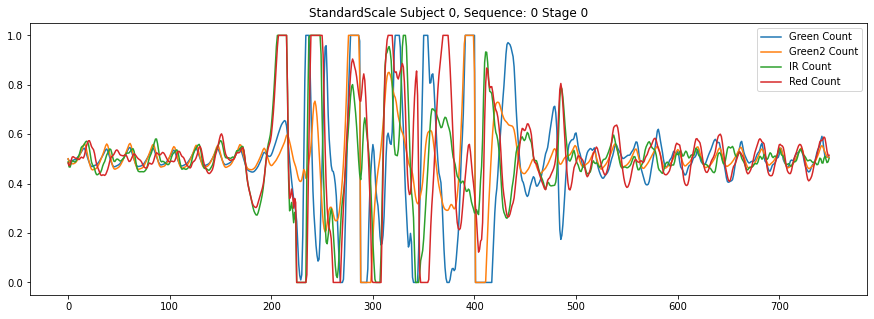

1.0 0.0 0.49625189582925044 0.3078811669413044
1.0 0.0 0.49355976748022506 0.32143169319761633
1.0 0.0 0.49321209890293355 0.25296438748161426
1.0 0.0 0.5021681282631442 0.31244460563982784


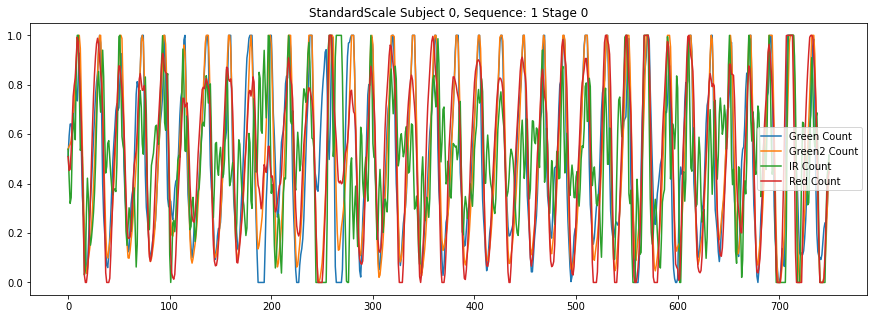

1.0 0.0 0.49477572095179495 0.202939595807728
1.0 0.0 0.4984941077328657 0.3161445375903344
1.0 0.0 0.5040375279654395 0.18206683532452705
1.0 0.0 0.5034229472056836 0.27271958863673074


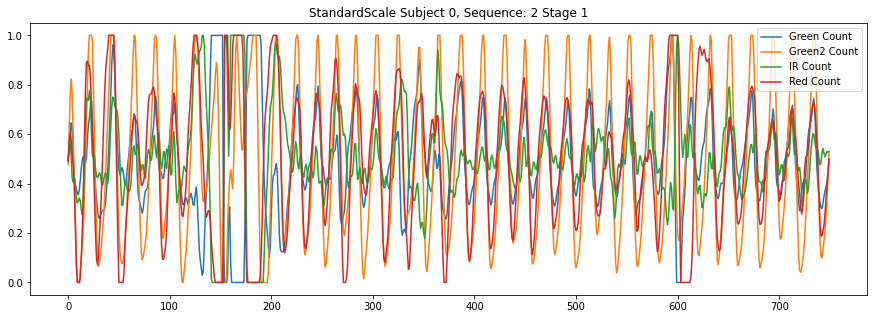

1.0 0.0 0.5026695107197295 0.18618694544451547
1.0 0.0 0.5010506647763864 0.12623061533215882
1.0 0.0 0.4992555829207362 0.18593057501690524
1.0 0.0 0.5013253055511593 0.185881590044727


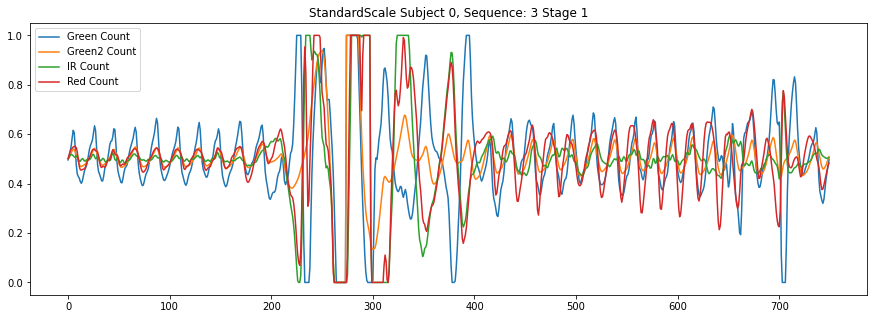

1.0 0.0 0.5043862807742793 0.27152525946136374
0.9999999999999999 0.0 0.49359284347270616 0.32178034485101337
1.0 0.0 0.5005969746366167 0.2029900106775087
1.0 0.0 0.501744236585482 0.2703644191136678


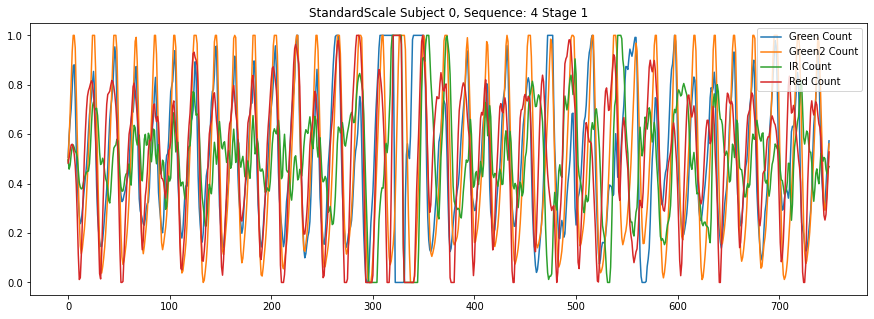

In [30]:
import matplotlib.pyplot as plt 

for j in range(5): 

    plt.figure(figsize=(15,5)) 
    for i in range(4):  # raw.shape[-1]): 

        sig = raw[j, :, i]  
        print(max(sig), min(sig), np.mean(sig), np.std(sig))
        # mms_re = sss.fit_transform(sig.reshape(-1,1))
        # mms_re = mms_re.flatten()
        # data_epoch[col] = mms_re 

        # plt.plot(mms_re)
        plt.plot(sig)
        plt.title(f'StandardScale Subject 0, Sequence: {j} Stage {label[j]}') 
    plt.legend(cols)
    plt.show()
 

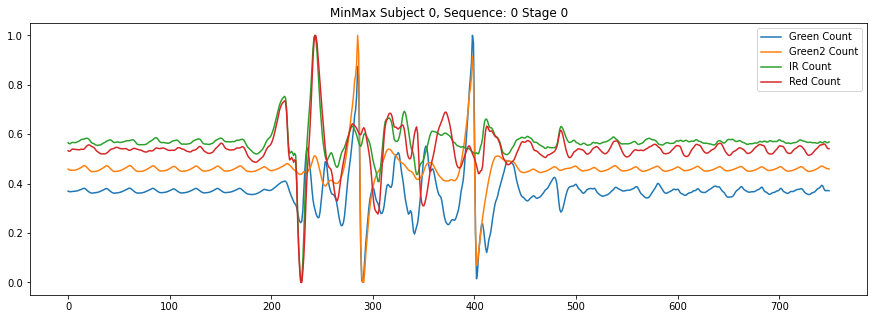

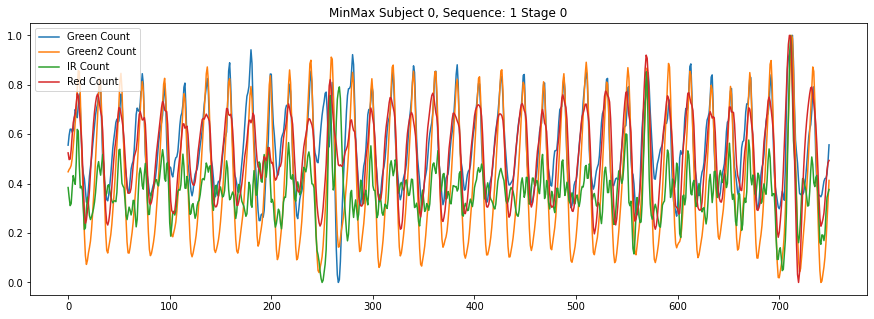

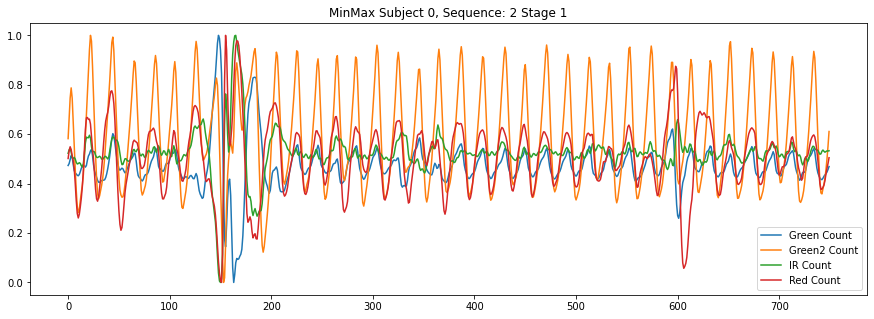

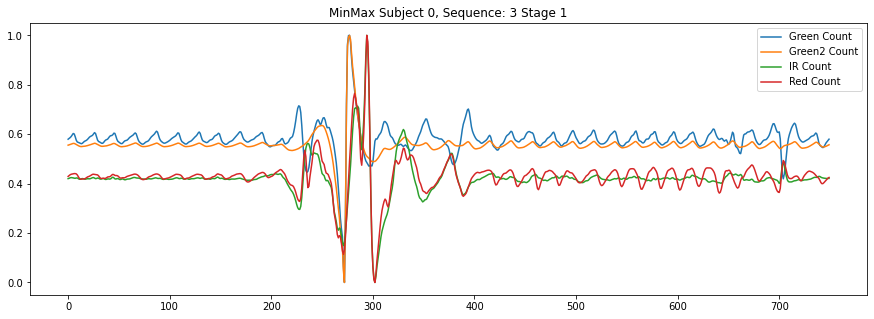

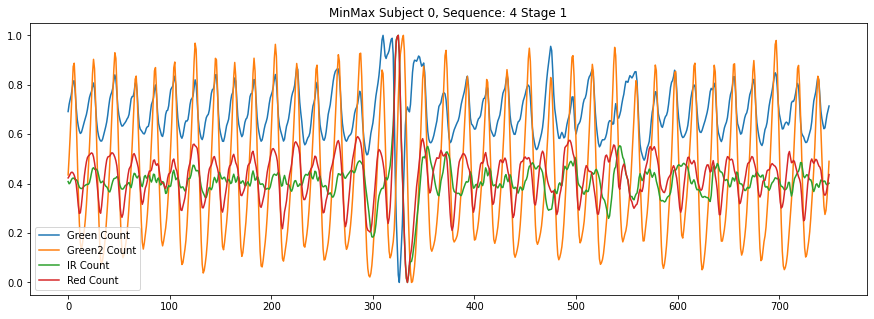

In [13]:

for j in range(5): 

    plt.figure(figsize=(15,5)) 
    for i in range(4):  # raw.shape[-1]): 

        sig = raw[j, :, i]  
        mms_re = mms.fit_transform(sig.reshape(-1,1))
        mms_re = mms_re.flatten()
        # data_epoch[col] = mms_re 

        plt.plot(mms_re)
        plt.title(f'MinMax Subject 0, Sequence: {j} Stage {label[j]}') 
    plt.legend(sig_cols)
    plt.show()
 

(785, 750, 15) (785,) ['Green Count' 'Green2 Count' 'IR Count' 'Red Count'
 'X Axis Acceleration (g)' 'Y Axis Acceleration (g)'
 'Z Axis Acceleration (g)' 'Heart Rate (bpm)' 'R Value' 'SpO2 (%)'
 'Time24' 'Stage' 'Stage_as_num' 'Motion' 'MovingAvg']


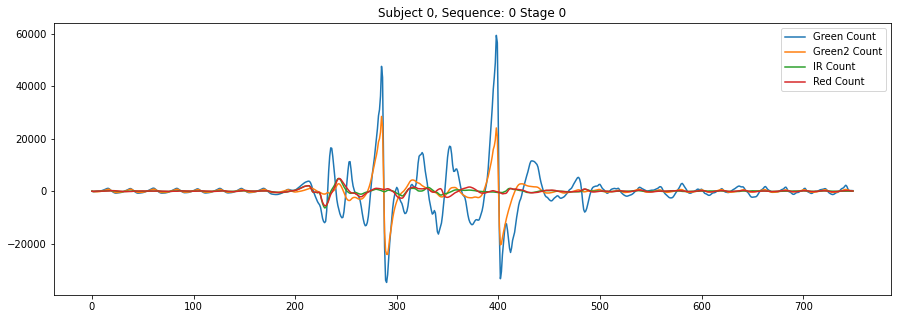

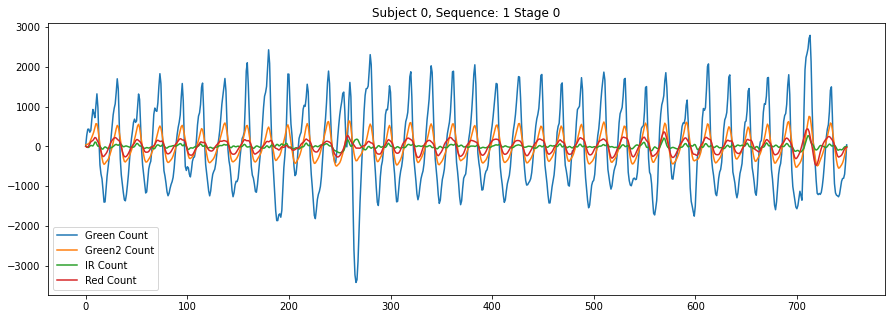

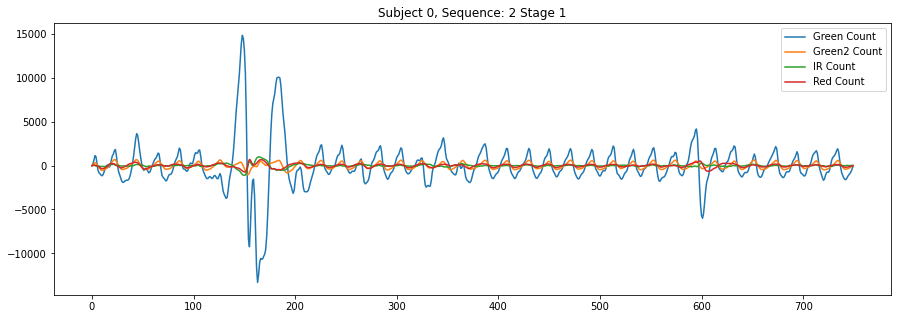

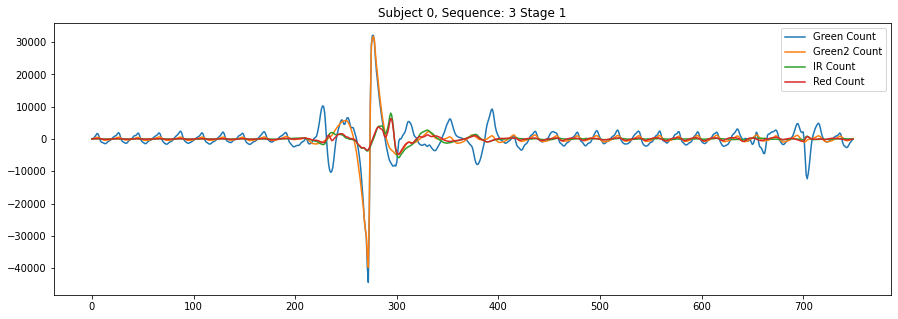

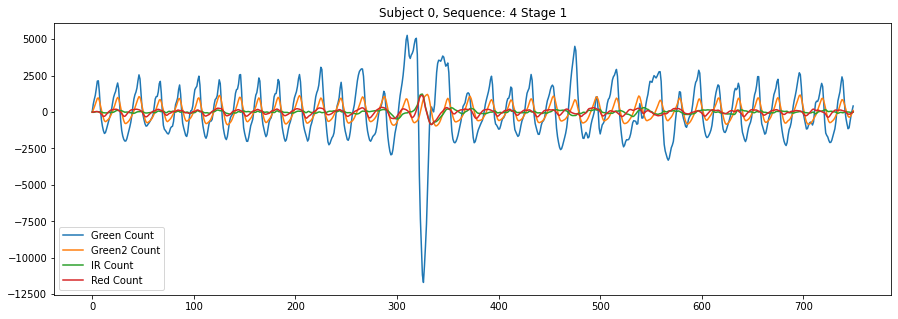

In [8]:
import matplotlib.pyplot as plt 
import numpy as np 

file = np.load(list_files[0], allow_pickle=True)
raw, label, sig_cols = file['x'], file['y'], file['cols']
print(raw.shape, label.shape, sig_cols)

# sig_cols = ["Green Count", "Green2 Count", "IR Count", "Red Count" ] 

for j in range(5): 

    plt.figure(figsize=(15,5)) 
    for i in range(4):  # raw.shape[-1]): 
        plt.plot(raw[j, :, i])
        plt.title(f'Subject 0, Sequence: {j} Stage {label[j]}') 
    plt.legend(sig_cols)
    plt.show()

In [10]:
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from scipy.signal import cheby2, lfilter, resample
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import torch
from torch.utils.data import Dataset


class LoadDataset_from_numpy(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, np_dataset, num_classes=5, esize=12, augmentation=None, max_shift=0.15):

        super(LoadDataset_from_numpy, self).__init__()
        X = []
        y = []
        mms = MinMaxScaler() #RobustScaler()
        print('No. of Dataset', len(np_dataset), 'Epoch size', esize)
        for _, np_file in enumerate(tqdm(np_dataset)):
            
            file = np.load(np_file)
            raw, label = file['x'], file['y']
            num_sig = raw.shape[0] 
            sig_len = raw.shape[1] 
            
            fs = sig_len / 30 
            if augmentation is not None:

                shiftno = 10 
                shifts = np.linspace(0, max_shift, num=shiftno) 

                for shift_value in shifts: 
                    
                    shift_amount = int(sig_len * shift_value)                
                    for sigidx in range(num_sig):
                        if sigidx < esize:
                            rep = np.tile(raw[:1,:,:], (esize - sigidx - 1,1,1)) # 
                            value = np.concatenate((rep, raw[:sigidx+1,:,:]),axis=0).reshape(-1, 1) 
                        else:
                            value = raw[sigidx - esize: sigidx, :, :].reshape(-1, 1)                     
                        if (shift_amount > 0) & (sigidx >= esize): 

                            sig_to_append = raw[sigidx-esize-1] 
                            start = sig_len - shift_amount
                            sig_to_append = sig_to_append[start:, :]
                        
                            value = value[:-shift_amount] 
                            value = np.concatenate([sig_to_append, value])  
                        X.append(value) # (1500,1) 
                        y.append(label[sigidx])
            else:
                for sigidx in range(num_sig):
                    if sigidx < esize:
                        rep = np.tile(raw[:1,:,:], (esize - sigidx - 1,1,1)) # 
                        value = np.concatenate((rep, raw[:sigidx+1,:,:]),axis=0).reshape(-1, 1) 
                    else:
                        value = raw[sigidx - esize: sigidx, :, :].reshape(-1, 1)
                    X.append(value) 
                    y.append(label[sigidx]) 

        X_train = np.stack((X), axis=0) 
        y_train = np.array(y)
        print('Shape Before Augmentation:', X_train.shape, y_train.shape)

        ## Classes
        if num_classes == 4:
            y_train = np.array([convert4class(x) for x in y_train])
        elif num_classes == 3:
            y_train = np.array([convert3class(x) for x in y_train])        
        elif num_classes == 5:
            y_train = y_train
        else:
            print("class 개수가 잘못되었습니다.")

        bin_labels = np.bincount(y_train)
        print(f"Labels count before Augmentation: {bin_labels}. \
              Major percentage: {100*np.max(bin_labels)/np.sum(bin_labels):.3f}")
        
        ## Augmentation        
        X_origin = X_train.copy()
        if augmentation == "SMOTE":
            print(f"Apply {augmentation}")
            X_train, y_train = SMOTE().fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), y_train)
            X_train = X_train.reshape(X_train.shape[0], X_origin.shape[1], X_origin.shape[2])
        elif augmentation == "TLink":
            print(f"Apply {augmentation}")
            X_train, y_train = TomekLinks(sampling_strategy="all", n_jobs=8).fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), y_train)
            X_train = X_train.reshape(X_train.shape[0], X_origin.shape[1], X_origin.shape[2])
        else:
            pass

        self.len = X_train.shape[0]
        self.x_data = torch.from_numpy(X_train)
        self.y_data = torch.from_numpy(y_train).long()
        self.num_classes = num_classes

        # Correcting the shape of input to be (Batch_size, #channels, seq_len) where #channels=1
        if len(self.x_data.shape) == 3:
            if self.x_data.shape[1] != 1:
                self.x_data = self.x_data.permute(0, 2, 1)
        else:
            self.x_data = self.x_data.unsqueeze(1)
        
        bin_labels = np.bincount(self.y_data)
        print(X_train.shape, y_train.shape)
        print(f"Labels count: {bin_labels}. Major percentage: {100*np.max(bin_labels)/np.sum(bin_labels):.3f}")
        # print(f"Shape of Input : {self.x_data.shape}")
        # print(f"Shape of Labels : {self.y_data.shape}")

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len
    def __getlabel__(self):
        return self.y_data.numpy()

def data_generator_np(training_files, subject_files, batch_size, num_classes = 5, num_workers=4, esize=12, augmentation="s"):
    train_dataset = LoadDataset_from_numpy(training_files, num_classes = num_classes, esize=esize, augmentation=augmentation)
    test_dataset = LoadDataset_from_numpy(subject_files, num_classes = num_classes, esize=esize)

    # to calculate the ratio for the CAL
    all_ys = np.concatenate((train_dataset.y_data, test_dataset.y_data))
    all_ys = all_ys.tolist()
    num_classes = len(np.unique(all_ys))
    counts = [all_ys.count(i) for i in range(num_classes)]

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               drop_last=False,
                                               num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              drop_last=False,
                                              num_workers=num_workers)

    return train_loader, test_loader, counts

## S0(Wake):0, S1:1, S2:2, S3:3, REM:4
def convert3class(y): 
    if y >= 4: ## REM 
        return 2
    ## NON-REM 
    if y == 3: ## DeepSleep 
        return 1
    if y == 2: ## & 1 LightSleep 
        return 1
    else:      # 0 Wake 
        return y

def convert4class(y):
    if y >= 4: ## REM
        return 3
    ## NON-REM 
    if y == 3: ## DeepSleep
        return 2
    if y == 2: ## & 1 LightSleep 
        return 1
    else:      ## wake = 0
        return y


In [11]:
test_dataset = LoadDataset_from_numpy(list_files[0:3], num_classes = 4, esize = 12)  
nx, ny = next(iter(test_dataset))
nx.shape, ny.shape, len(test_dataset)  

No. of Dataset 3 Epoch size 12


100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


Shape Before Augmentation: (1935, 36000, 1) (1935,)
Labels count before Augmentation: [ 127 1203  216  389].               Major percentage: 62.171
(1935, 36000, 1) (1935,)
Labels count: [ 127 1203  216  389]. Major percentage: 62.171
Shape of Input : torch.Size([1935, 1, 36000])
Shape of Labels : torch.Size([1935])


(torch.Size([1, 36000]), torch.Size([]), 1935)

In [14]:
nx.shape

torch.Size([1, 36000])